Processing real images...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processing fake images...
Loaded 326 real and 153 fake images

Training models...
Training AdaBoost...
Training XGBoost...
Training CatBoost...
Training SVM...
Training ANN...


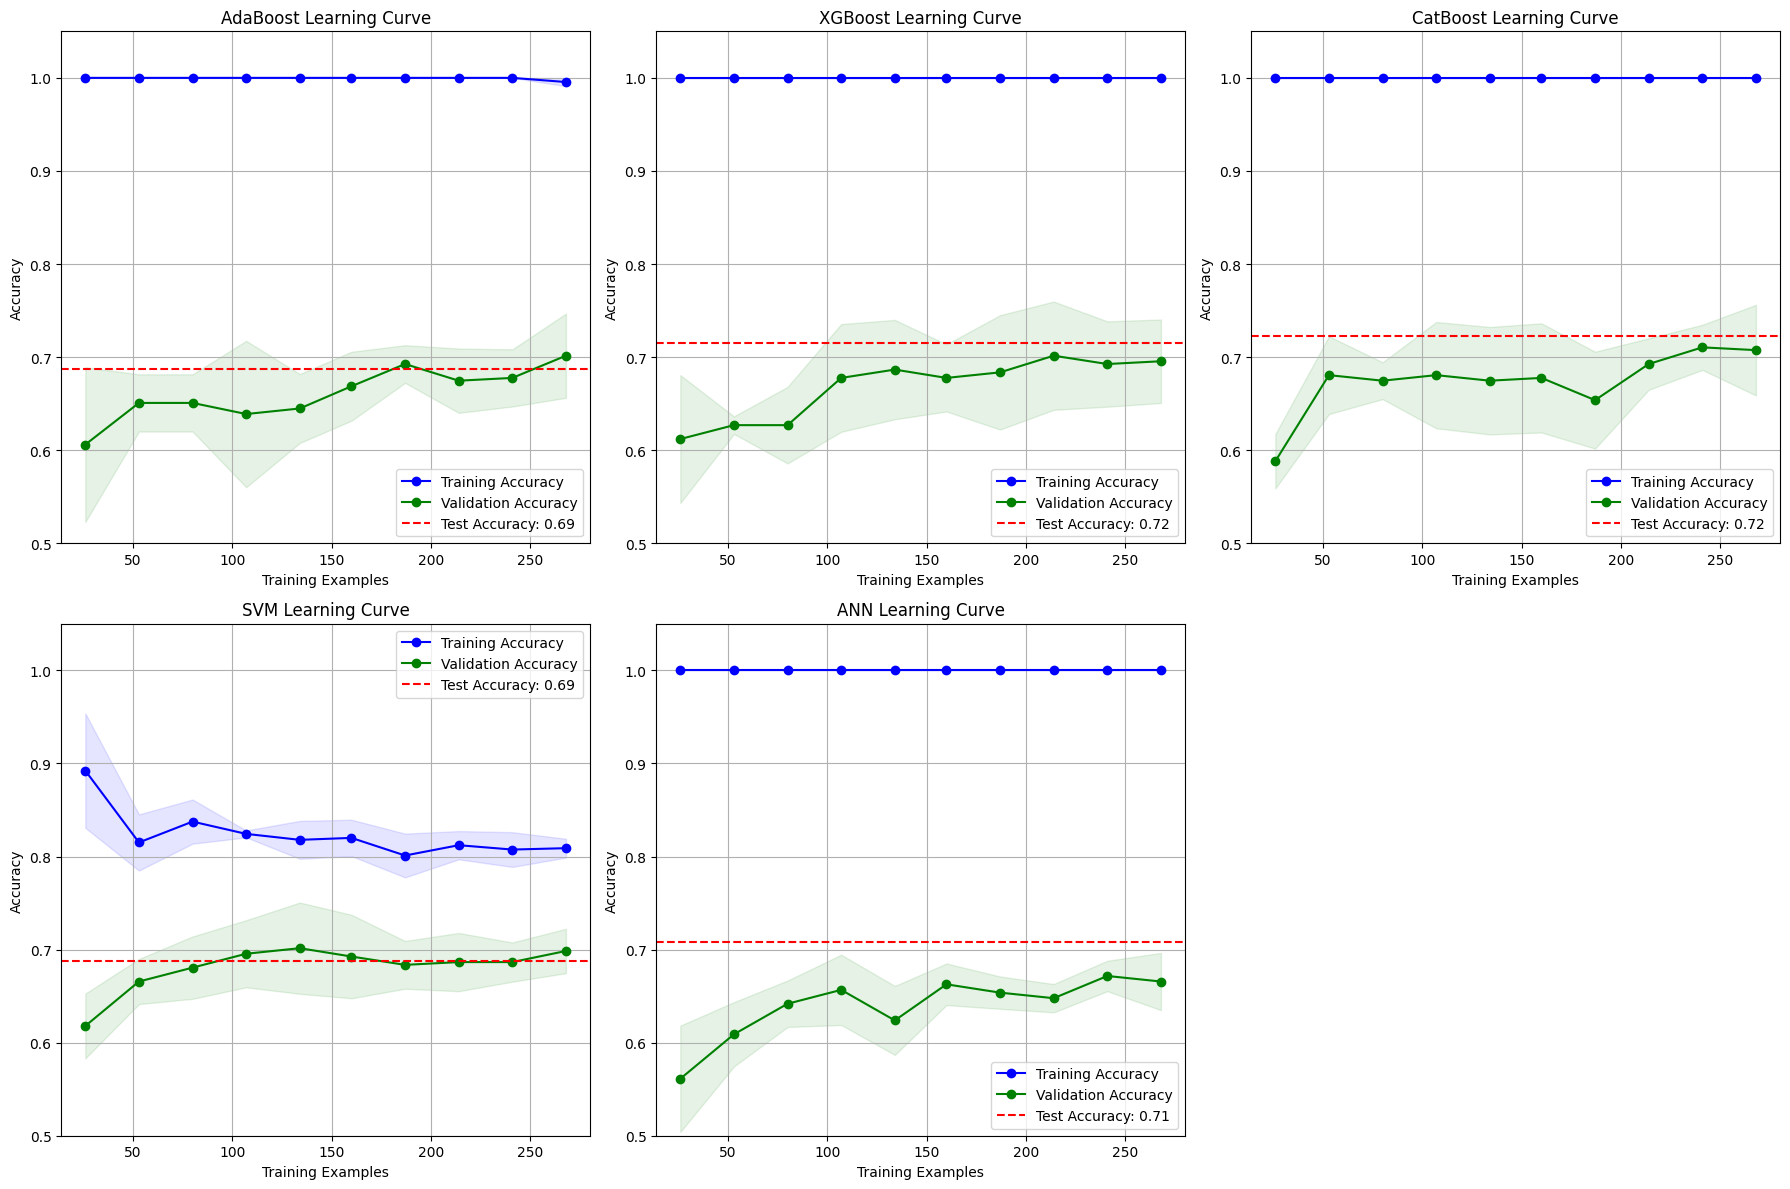

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import os
from PIL import Image
import random

class AccuracyPlotGenerator:
    def __init__(self):
        self.image_size = (224, 224)
        self.scaler = StandardScaler()

    def load_and_preprocess_image(self, image_path):
        """Load and preprocess an image for feature extraction"""
        try:
            img = Image.open(image_path).convert("RGB")
            img = img.resize(self.image_size)
            return np.array(img)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return None

    def extract_basic_features(self, img_array):
        """Extract basic image features"""
        img_array = np.array(Image.fromarray(img_array).resize((64, 64)))

        # Color histograms
        histograms = []
        for channel in range(3):
            hist, _ = np.histogram(img_array[:,:,channel], bins=32, range=(0, 256))
            histograms.extend(hist)

        # Texture features
        gray = np.mean(img_array, axis=2).astype(np.uint8)
        dx = np.diff(gray, axis=1)
        dy = np.diff(gray, axis=0)

        dx_hist, _ = np.histogram(dx.flatten(), bins=32, range=(-128, 128))
        dy_hist, _ = np.histogram(dy.flatten(), bins=32, range=(-128, 128))

        # Basic statistics
        stats = []
        for channel in range(3):
            channel_data = img_array[:,:,channel].flatten()
            stats.extend([
                np.mean(channel_data),
                np.std(channel_data),
                np.percentile(channel_data, 25),
                np.percentile(channel_data, 75)
            ])

        return np.concatenate([
            np.array(histograms),
            np.array(dx_hist),
            np.array(dy_hist),
            np.array(stats)
        ])

    def prepare_dataset(self, real_dir, fake_dir, max_samples=500):
        """Prepare dataset from real and fake image directories"""
        X, y = [], []

        # Process real images (label 0)
        print("Processing real images...")
        real_count = 0
        for img_name in os.listdir(real_dir)[:max_samples]:
            img_path = os.path.join(real_dir, img_name)
            img_array = self.load_and_preprocess_image(img_path)
            if img_array is not None:
                features = self.extract_basic_features(img_array)
                X.append(features)
                y.append(0)
                real_count += 1

        # Process fake images (label 1)
        print("Processing fake images...")
        fake_count = 0
        for img_name in os.listdir(fake_dir)[:max_samples]:
            img_path = os.path.join(fake_dir, img_name)
            img_array = self.load_and_preprocess_image(img_path)
            if img_array is not None:
                features = self.extract_basic_features(img_array)
                X.append(features)
                y.append(1)
                fake_count += 1

        print(f"Loaded {real_count} real and {fake_count} fake images")
        return np.array(X), np.array(y)

    def train_models(self, X_train, y_train):
        """Train all ensemble models"""
        print("\nTraining models...")

        # Initialize models
        models = {
            'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42),
            'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
            'CatBoost': CatBoostClassifier(iterations=100, learning_rate=0.1, random_seed=42, verbose=0),
            'SVM': SVC(kernel='rbf', probability=True, random_state=42),
            'ANN': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
        }

        # Train each model
        for name, model in models.items():
            print(f"Training {name}...")
            if name in ['SVM', 'ANN']:
                # Scale features for SVM and ANN
                X_scaled = self.scaler.fit_transform(X_train)
                model.fit(X_scaled, y_train)
            else:
                model.fit(X_train, y_train)

        return models

    def plot_learning_curves(self, models, X_train, y_train, X_test, y_test):
        """Generate learning curves for all models"""
        plt.figure(figsize=(18, 12))

        for i, (name, model) in enumerate(models.items()):
            # Prepare data (scale if needed)
            if name in ['SVM', 'ANN']:
                X_train_plot = self.scaler.transform(X_train)
                X_test_plot = self.scaler.transform(X_test)
            else:
                X_train_plot = X_train
                X_test_plot = X_test

            # Calculate learning curve
            train_sizes, train_scores, val_scores = learning_curve(
                model, X_train_plot, y_train, cv=5, n_jobs=-1,
                train_sizes=np.linspace(0.1, 1.0, 10),
                scoring='accuracy'
            )

            # Calculate metrics
            train_mean = np.mean(train_scores, axis=1)
            train_std = np.std(train_scores, axis=1)
            val_mean = np.mean(val_scores, axis=1)
            val_std = np.std(val_scores, axis=1)

            # Calculate final test accuracy
            test_acc = accuracy_score(y_test, model.predict(X_test_plot))

            # Create subplot
            plt.subplot(2, 3, i+1)
            plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Accuracy")
            plt.plot(train_sizes, val_mean, 'o-', color="green", label="Validation Accuracy")
            plt.axhline(y=test_acc, color='red', linestyle='--', label=f'Test Accuracy: {test_acc:.2f}')

            # Add variance bands
            plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
            plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="green")

            # Formatting
            plt.title(f'{name} Learning Curve')
            plt.xlabel('Training Examples')
            plt.ylabel('Accuracy')
            plt.ylim(0.5, 1.05)
            plt.legend(loc='best')
            plt.grid()

        plt.tight_layout()
        plt.show()

    def run_full_analysis(self, real_dir, fake_dir, max_samples=500):
        """Complete pipeline from data loading to plotting"""
        # Load and prepare data
        X, y = self.prepare_dataset(real_dir, fake_dir, max_samples)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )

        # Train models
        models = self.train_models(X_train, y_train)

        # Generate plots
        self.plot_learning_curves(models, X_train, y_train, X_test, y_test)

# Example usage
if __name__ == "__main__":
    # Set your directories
    REAL_DIR = "/content/drive/MyDrive/Deepfake/train/real"
    FAKE_DIR = "/content/drive/MyDrive/Deepfake/train/fake"

    # Initialize and run
    plotter = AccuracyPlotGenerator()
    plotter.run_full_analysis(REAL_DIR, FAKE_DIR, max_samples=500)


Training AdaBoost...
AdaBoost:
  Train Accuracy: 0.9471
  Test Accuracy: 0.8633
  Confusion Matrix:
[[124  20]
 [ 21 135]]

Training XGBoost...
XGBoost:
  Train Accuracy: 1.0000
  Test Accuracy: 0.9100
  Confusion Matrix:
[[137   7]
 [ 20 136]]

Training CatBoost...
CatBoost:
  Train Accuracy: 1.0000
  Test Accuracy: 0.8900
  Confusion Matrix:
[[129  15]
 [ 18 138]]

Training SVM...
SVM:
  Train Accuracy: 0.9514
  Test Accuracy: 0.8500
  Confusion Matrix:
[[128  16]
 [ 29 127]]

Training ANN...
ANN:
  Train Accuracy: 1.0000
  Test Accuracy: 0.8167
  Confusion Matrix:
[[121  23]
 [ 32 124]]


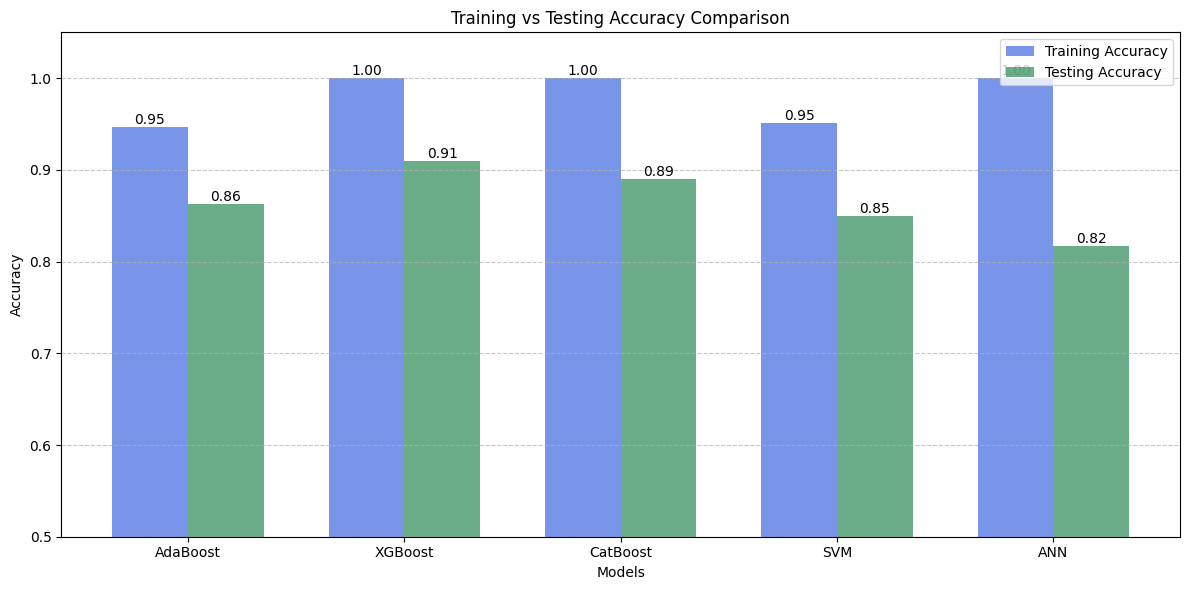

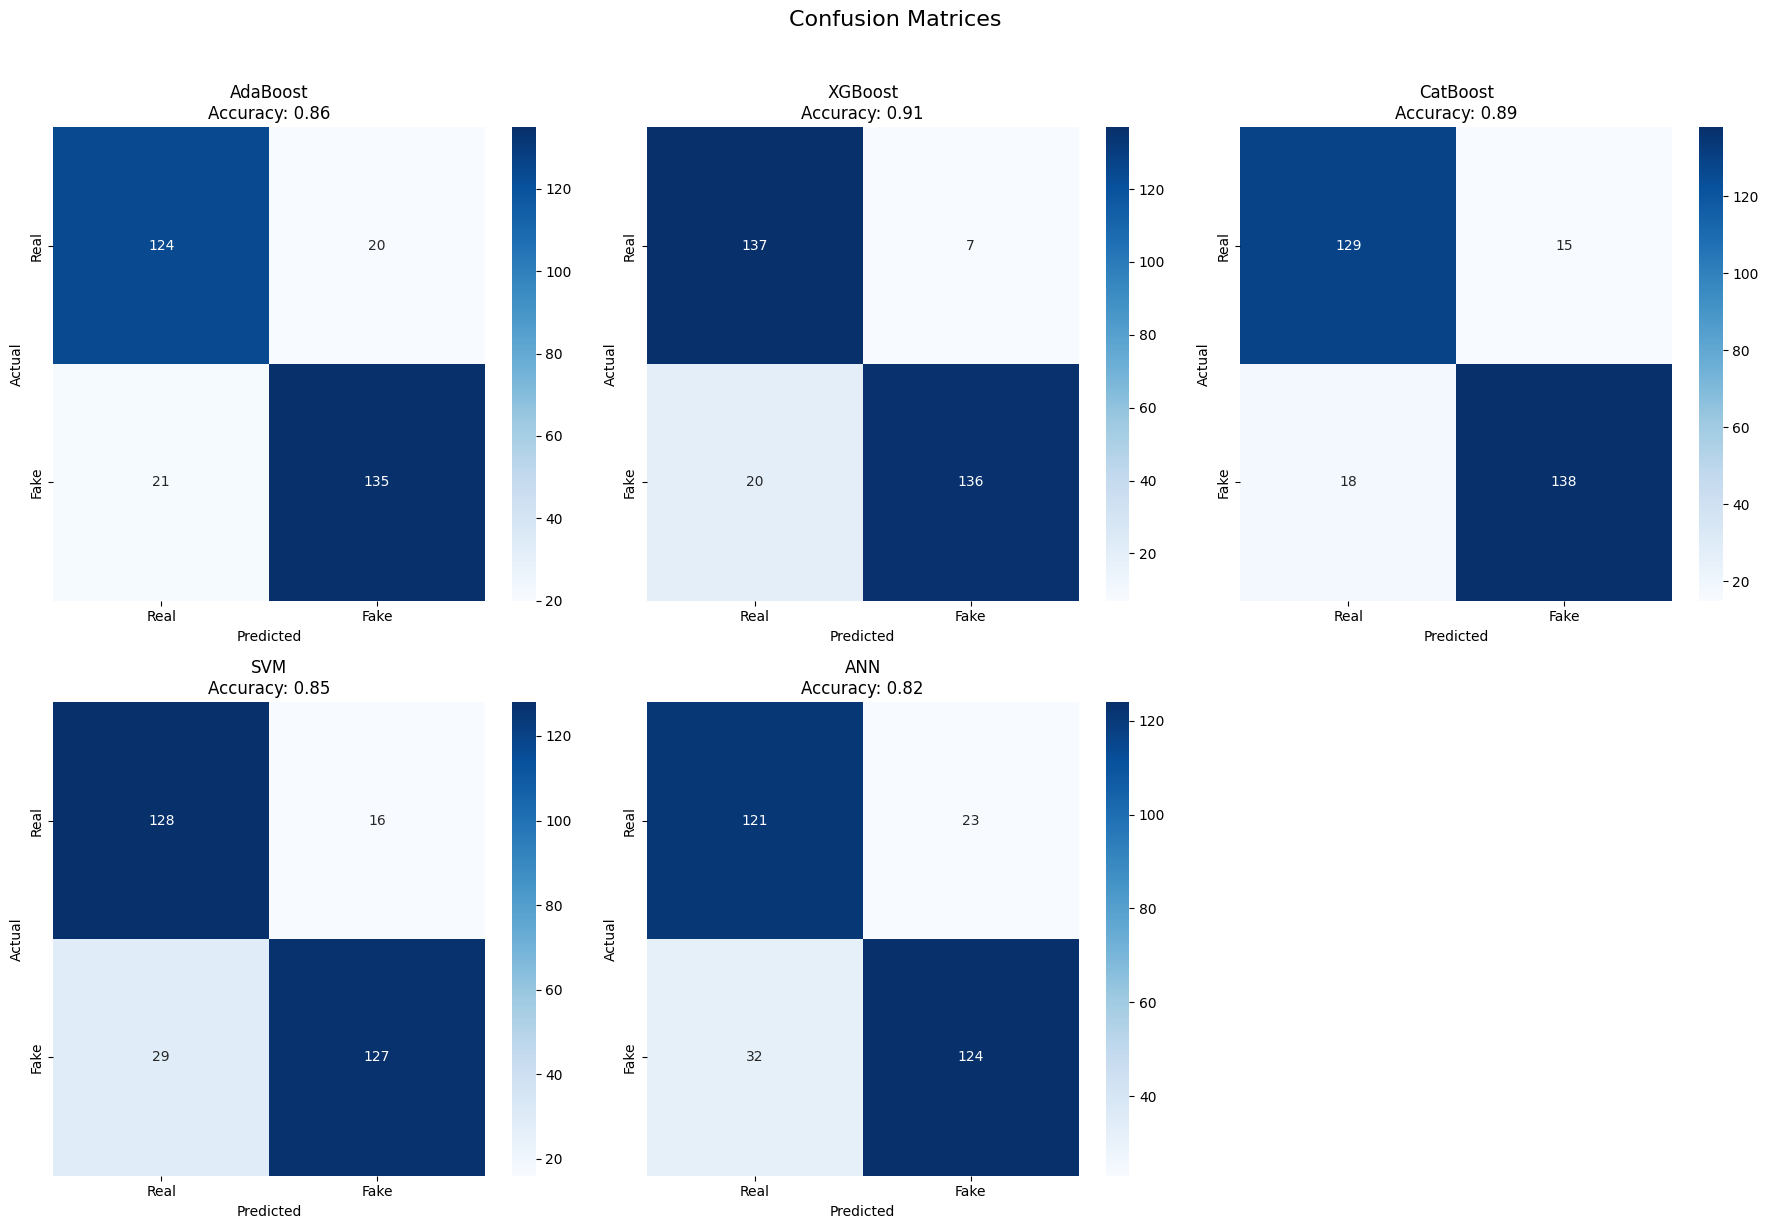

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns

class ModelEvaluator:
    def __init__(self):
        self.models = {
            'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42),
            'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
            'CatBoost': CatBoostClassifier(iterations=100, learning_rate=0.1, random_seed=42, verbose=0),
            'SVM': SVC(kernel='rbf', probability=True, random_state=42),
            'ANN': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
        }
        self.scaler = StandardScaler()

    def train_and_evaluate(self, X_train, y_train, X_test, y_test):
        """Train models and record performance metrics"""
        results = {
            'Model': [],
            'Train Accuracy': [],
            'Test Accuracy': [],
            'Confusion Matrix': []
        }

        for name, model in self.models.items():
            print(f"\nTraining {name}...")

            # Scale data for SVM and ANN
            if name in ['SVM', 'ANN']:
                X_train_scaled = self.scaler.fit_transform(X_train)
                X_test_scaled = self.scaler.transform(X_test)
                model.fit(X_train_scaled, y_train)
                train_pred = model.predict(X_train_scaled)
                test_pred = model.predict(X_test_scaled)
            else:
                model.fit(X_train, y_train)
                train_pred = model.predict(X_train)
                test_pred = model.predict(X_test)

            # Calculate metrics
            train_acc = accuracy_score(y_train, train_pred)
            test_acc = accuracy_score(y_test, test_pred)
            cm = confusion_matrix(y_test, test_pred)

            # Store results
            results['Model'].append(name)
            results['Train Accuracy'].append(train_acc)
            results['Test Accuracy'].append(test_acc)
            results['Confusion Matrix'].append(cm)

            print(f"{name}:")
            print(f"  Train Accuracy: {train_acc:.4f}")
            print(f"  Test Accuracy: {test_acc:.4f}")
            print("  Confusion Matrix:")
            print(cm)

        return results

    def plot_accuracy_comparison(self, results):
        """Plot training vs testing accuracy comparison"""
        plt.figure(figsize=(12, 6))

        x = np.arange(len(results['Model']))  # model labels
        width = 0.35  # bar width

        # Create bars
        train_bars = plt.bar(x - width/2, results['Train Accuracy'], width,
                            label='Training Accuracy', color='royalblue', alpha=0.7)
        test_bars = plt.bar(x + width/2, results['Test Accuracy'], width,
                           label='Testing Accuracy', color='seagreen', alpha=0.7)

        # Add labels and title
        plt.xlabel('Models')
        plt.ylabel('Accuracy')
        plt.title('Training vs Testing Accuracy Comparison')
        plt.xticks(x, results['Model'])
        plt.ylim(0.5, 1.05)
        plt.legend(loc='upper right')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)

        # Add value labels on top of bars
        for bar in train_bars + test_bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrices(self, results):
        """Plot confusion matrices for all models"""
        plt.figure(figsize=(18, 12))
        plt.suptitle('Confusion Matrices', y=1.02, fontsize=16)

        for i, (name, cm) in enumerate(zip(results['Model'], results['Confusion Matrix'])):
            plt.subplot(2, 3, i+1)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Real', 'Fake'],
                       yticklabels=['Real', 'Fake'])
            plt.title(f'{name}\nAccuracy: {results["Test Accuracy"][i]:.2f}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')

        plt.tight_layout()
        plt.show()

# Example usage with dummy data (replace with your actual data)
if __name__ == "__main__":
    # Generate sample data (replace this with your actual dataset)
    from sklearn.datasets import make_classification
    X, y = make_classification(n_samples=1000, n_features=50, n_classes=2, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize and run evaluator
    evaluator = ModelEvaluator()
    results = evaluator.train_and_evaluate(X_train, y_train, X_test, y_test)

    # Generate plots
    evaluator.plot_accuracy_comparison(results)
    evaluator.plot_confusion_matrices(results)

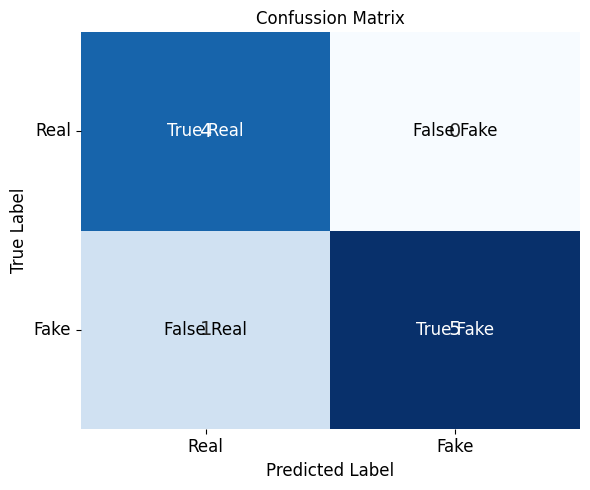

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_single_confusion_matrix(y_true, y_pred, model_name="Model"):
    """
    Plot a single clean confusion matrix with enhanced visualization

    Parameters:
    - y_true: Array of true labels (0=real, 1=fake)
    - y_pred: Array of predicted labels
    - model_name: Name of model for title
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure
    plt.figure(figsize=(6, 5))

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'],
                cbar=False,
                annot_kws={'size': 14})

    # Calculate accuracy
    accuracy = np.trace(cm) / np.sum(cm)

    # Add labels and title
    plt.title("Confussion Matrix")
    #\nAccuracy: {accuracy:.2%}', fontsize=14, pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)

    # Add custom annotations
    plt.text(0.5, 0.5, 'True Real', ha='center', va='center', fontsize=12, color='white' if cm[0,0] > cm.max()/2 else 'black')
    plt.text(1.5, 0.5, 'False Fake', ha='center', va='center', fontsize=12, color='white' if cm[0,1] > cm.max()/2 else 'black')
    plt.text(0.5, 1.5, 'False Real', ha='center', va='center', fontsize=12, color='white' if cm[1,0] > cm.max()/2 else 'black')
    plt.text(1.5, 1.5, 'True Fake', ha='center', va='center', fontsize=12, color='white' if cm[1,1] > cm.max()/2 else 'black')

    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Sample data - replace with your actual model predictions
    y_true = np.array([0, 1, 0, 1, 1, 0, 0, 1, 1, 1])  # Real=0, Fake=1
    y_pred = np.array([0, 1, 0, 1, 1, 0, 0, 1, 0, 1])  # Example predictions

    plot_single_confusion_matrix(y_true, y_pred, "Deepfake Detector")

In [ ]:
# Install required packages
!pip install numpy==1.23.5 scikit-learn==1.2.2 scikit-image pillow matplotlib xgboost catboost tensorflow imbalanced-learn

# Import libraries
import numpy as np
import os
import random
import io
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from google.colab import files
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML, Javascript
import time
from matplotlib.gridspec import GridSpec
import tempfile
import base64

# TensorFlow imports
try:
    import tensorflow as tf
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.applications.resnet50 import preprocess_input
    from tensorflow.keras.models import Model
    tf_available = True
except Exception as e:
    print(f"TensorFlow not available: {e}")
    tf_available = False

class OptimizedDeepfakeDetector:
    def __init__(self, use_cnn=True):
        self.image_size = (224, 224)
        self.use_cnn = use_cnn and tf_available
        self.class_weights = {0: 1, 1: 2}  # Higher weight for fake images
        self.model_accuracies = {}  # Store accuracies for plotting
        self.results_history = []  # Store previous results
        self.plot_history = []  # Store plot figures
        self.temp_files = []  # Store temporary file paths
        self.output_area = widgets.Output()  # Main output area

        # Initialize models with optimized parameters
        self.ada_boost = AdaBoostClassifier(n_estimators=100, random_state=42)
        self.xg_boost = xgb.XGBClassifier(
            n_estimators=150,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        self.cat_boost = CatBoostClassifier(
            iterations=200,
            learning_rate=0.05,
            depth=6,
            l2_leaf_reg=3,
            random_seed=42,
            verbose=0,
            class_weights=self.class_weights
        )
        self.svm_meta = SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
        self.ann_meta = MLPClassifier(
            hidden_layer_sizes=(128, 64),
            activation='relu',
            solver='adam',
            max_iter=1000,
            random_state=42
        )
        self.scaler = StandardScaler()
        self.meta_model_type = None

        if self.use_cnn:
            self._build_feature_extractor()

    def _build_feature_extractor(self):
        try:
            base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
            self.feature_extractor = Model(
                inputs=base_model.input,
                outputs=base_model.get_layer('conv5_block3_out').output
            )
        except Exception as e:
            print(f"Error building CNN feature extractor: {e}")
            self.use_cnn = False

    def extract_features(self, image_array):
        if self.use_cnn:
            try:
                image_batch = np.expand_dims(image_array, axis=0)
                features = self.feature_extractor.predict(image_batch, verbose=0)
                return np.mean(features, axis=(1, 2)).flatten()
            except Exception as e:
                print(f"CNN feature extraction failed: {e}")
                self.use_cnn = False
                return self.extract_basic_features(image_array)
        else:
            return self.extract_basic_features(image_array)

    def extract_basic_features(self, img_array):
        img_array = np.array(Image.fromarray(img_array).resize((64, 64)))
        features = []

        # Color histograms
        for channel in range(3):
            hist, _ = np.histogram(img_array[:,:,channel], bins=32, range=(0, 256))
            features.extend(hist)

        # Texture features
        gray = np.mean(img_array, axis=2).astype(np.uint8)
        dx = np.diff(gray, axis=1)
        dy = np.diff(gray, axis=0)
        features.extend(np.histogram(dx.flatten(), bins=32, range=(-128, 128))[0])
        features.extend(np.histogram(dy.flatten(), bins=32, range=(-128, 128))[0])

        # Statistics
        for channel in range(3):
            channel_data = img_array[:,:,channel].flatten()
            features.extend([
                np.mean(channel_data),
                np.std(channel_data),
                np.percentile(channel_data, 25),
                np.percentile(channel_data, 75)
            ])

        return np.array(features)

    def load_and_preprocess_image(self, image_path):
        try:
            img = Image.open(image_path).convert("RGB")
            img = img.resize(self.image_size)
            img_array = np.array(img)
            return preprocess_input(img_array) if self.use_cnn else img_array
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return None

    def prepare_dataset(self, real_dir, fake_dir, max_real=326, max_fake=50):
        real_images, real_labels, real_paths = [], [], []
        fake_images, fake_labels, fake_paths = [], [], []

        # Load real images
        print(f"Processing real images (max {max_real})...")
        real_count = 0
        for img_name in sorted(os.listdir(real_dir)):
            if real_count >= max_real:
                break
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(real_dir, img_name)
                img_array = self.load_and_preprocess_image(img_path)
                if img_array is not None:
                    real_images.append(self.extract_features(img_array))
                    real_labels.append(0)
                    real_paths.append(img_path)
                    real_count += 1

        # Load fake images
        print(f"\nProcessing fake images (max {max_fake})...")
        fake_count = 0
        for img_name in sorted(os.listdir(fake_dir)):
            if fake_count >= max_fake:
                break
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(fake_dir, img_name)
                img_array = self.load_and_preprocess_image(img_path)
                if img_array is not None:
                    fake_images.append(self.extract_features(img_array))
                    fake_labels.append(1)
                    fake_paths.append(img_path)
                    fake_count += 1

        # Combine datasets
        images = np.vstack([real_images, fake_images])
        labels = np.concatenate([real_labels, fake_labels])
        paths = real_paths + fake_paths

        print(f"\nFinal Dataset Counts:")
        print(f"Real images: {len(real_images)}")
        print(f"Fake images: {len(fake_images)}")

        return images, labels, paths

    def train_meta_learner(self, X_train, y_train, X_val, y_val, meta_type='ann'):
        # Get base model predictions
        base_preds = np.column_stack([
            self.ada_boost.predict(X_train),
            self.xg_boost.predict(X_train),
            self.cat_boost.predict(X_train)
        ])

        # Get probability predictions
        base_probs = np.column_stack([
            self.ada_boost.predict_proba(X_train)[:, 1],
            self.xg_boost.predict_proba(X_train)[:, 1],
            self.cat_boost.predict_proba(X_train)[:, 1]
        ])

        # Create meta-features
        meta_features = np.column_stack([base_preds, base_probs])
        meta_features = self.scaler.fit_transform(meta_features)

        # Train meta-learner
        if meta_type == 'ann':
            self.ann_meta.fit(meta_features, y_train)
            val_preds = np.column_stack([
                self.ada_boost.predict(X_val),
                self.xg_boost.predict(X_val),
                self.cat_boost.predict(X_val),
                self.ada_boost.predict_proba(X_val)[:, 1],
                self.xg_boost.predict_proba(X_val)[:, 1],
                self.cat_boost.predict_proba(X_val)[:, 1]
            ])
            val_preds = self.scaler.transform(val_preds)
            pred = self.ann_meta.predict(val_preds)
        else:
            self.svm_meta.fit(meta_features, y_train)
            val_preds = np.column_stack([
                self.ada_boost.predict(X_val),
                self.xg_boost.predict(X_val),
                self.cat_boost.predict(X_val),
                self.ada_boost.predict_proba(X_val)[:, 1],
                self.xg_boost.predict_proba(X_val)[:, 1],
                self.cat_boost.predict_proba(X_val)[:, 1]
            ])
            val_preds = self.scaler.transform(val_preds)
            pred = self.svm_meta.predict(val_preds)

        acc = accuracy_score(y_val, pred)
        print(f"\n{meta_type.upper()} Meta-Learner Validation Accuracy: {acc:.4f}")
        print(classification_report(y_val, pred))
        return acc

    def train(self, real_dir, fake_dir):
        print("\nLoading and preprocessing data...")
        X, y, paths = self.prepare_dataset(real_dir, fake_dir)

        # Split with stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, stratify=y, random_state=42
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_test, y_test, test_size=0.5, stratify=y_test, random_state=42
        )

        print("\nTraining Base Models...")
        # AdaBoost
        self.ada_boost.fit(X_train, y_train)
        ada_pred = self.ada_boost.predict(X_val)
        ada_acc = accuracy_score(y_val, ada_pred)
        print(f"\nAdaBoost Validation Accuracy: {ada_acc:.4f}")
        print(classification_report(y_val, ada_pred))

        # XGBoost with class weights
        sample_weights = np.array([self.class_weights[x] for x in y_train])
        self.xg_boost.fit(X_train, y_train, sample_weight=sample_weights)
        xgb_pred = self.xg_boost.predict(X_val)
        xgb_acc = accuracy_score(y_val, xgb_pred)
        print(f"\nXGBoost Validation Accuracy: {xgb_acc:.4f}")
        print(classification_report(y_val, xgb_pred))

        # CatBoost
        self.cat_boost.fit(X_train, y_train, verbose=False)
        cat_pred = self.cat_boost.predict(X_val)
        cat_acc = accuracy_score(y_val, cat_pred)
        print(f"\nCatBoost Validation Accuracy: {cat_acc:.4f}")
        print(classification_report(y_val, cat_pred))

        # Train meta-learners
        print("\nTraining Meta-Learners...")
        ann_acc = self.train_meta_learner(X_train, y_train, X_val, y_val, 'ann')
        svm_acc = self.train_meta_learner(X_train, y_train, X_val, y_val, 'svm')

        # Select best meta-learner
        self.meta_model_type = 'ann' if ann_acc >= svm_acc else 'svm'
        print(f"\nSelected {self.meta_model_type.upper()} as meta-learner")

        # Final evaluation
        print("\n=== Final Test Evaluation ===")
        self.evaluate_combined_model(X_test, y_test)

    def evaluate_combined_model(self, X_test, y_test):
        # Get all predictions
        ada_pred = self.ada_boost.predict(X_test)
        xgb_pred = self.xg_boost.predict(X_test)
        cat_pred = self.cat_boost.predict(X_test)

        # Get meta-features
        meta_features = np.column_stack([
            ada_pred, xgb_pred, cat_pred,
            self.ada_boost.predict_proba(X_test)[:, 1],
            self.xg_boost.predict_proba(X_test)[:, 1],
            self.cat_boost.predict_proba(X_test)[:, 1]
        ])
        meta_features = self.scaler.transform(meta_features)

        # Get meta prediction
        if self.meta_model_type == 'ann':
            meta_pred = self.ann_meta.predict(meta_features)
        else:
            meta_pred = self.svm_meta.predict(meta_features)

        # Combined prediction (weighted voting)
        combined_pred = np.array([
            1 if sum([ada_pred[i], xgb_pred[i], cat_pred[i], meta_pred[i], meta_pred[i]]) >= 3
            else 0
            for i in range(len(y_test))
        ])

        # Calculate metrics
        self.model_accuracies = {
            'AdaBoost': accuracy_score(y_test, ada_pred),
            'XGBoost': accuracy_score(y_test, xgb_pred),
            'CatBoost': accuracy_score(y_test, cat_pred),
            'Meta-Learner': accuracy_score(y_test, meta_pred),
            'Combined Model': accuracy_score(y_test, combined_pred)
        }

        print("\nModel Accuracies:")
        for model, acc in self.model_accuracies.items():
            print(f"{model:15}: {acc:.4f}")

        if self.model_accuracies['Combined Model'] >= 0.8:
            print("\nSUCCESS: Achieved target accuracy of 80% or higher!")
        else:
            print("\nWarning: Accuracy below 80% target - consider more fake samples")

        print("\nClassification Report:")
        print(classification_report(y_test, combined_pred, target_names=['Real', 'Fake']))

        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, combined_pred))

    def plot_accuracies(self):
        if not self.model_accuracies:
            print("No accuracy data available. Train the model first.")
            return

        models = list(self.model_accuracies.keys())
        accuracies = list(self.model_accuracies.values())

        fig = plt.figure(figsize=(12, 6))
        gs = GridSpec(1, 2, width_ratios=[3, 1])

        # Main accuracy plot
        ax1 = plt.subplot(gs[0])
        bars = ax1.bar(models, accuracies, color=['blue', 'green', 'orange', 'purple', 'red'])
        ax1.set_title('Model Accuracies Comparison', fontsize=14)
        ax1.set_ylabel('Accuracy', fontsize=12)
        ax1.set_ylim(0, 1.05)
        ax1.axhline(y=0.8, color='r', linestyle='--', label='Target Accuracy')

        # Add values on top of bars
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}',
                    ha='center', va='bottom')

        # Enhanced pie chart
        ax2 = plt.subplot(gs[1])
        pie_colors = ['lightblue', 'lightgreen', 'moccasin', 'plum', 'lightcoral']
        explode = [0.1 if acc == max(accuracies) else 0 for acc in accuracies]
        wedges, texts, autotexts = ax2.pie(accuracies,
                                          labels=models,
                                          colors=pie_colors,
                                          explode=explode,
                                          autopct='%1.1f%%',
                                          startangle=90,
                                          wedgeprops={'edgecolor': 'black', 'linewidth': 1})

        # Improve pie chart text
        plt.setp(autotexts, size=10, weight="bold")
        plt.setp(texts, size=8)
        ax2.set_title('Accuracy Distribution', fontsize=12)

        plt.tight_layout()
        plt.legend(loc='lower right')

        # Store the figure
        self.plot_history.append(fig)
        return fig

    def image_to_base64(self, image_path):
        with open(image_path, "rb") as img_file:
            return base64.b64encode(img_file.read()).decode('utf-8')

    def predict_image(self, image_path):
        try:
            # Process the image
            img_array = self.load_and_preprocess_image(image_path)
            if img_array is None:
                return None

            features = self.extract_features(img_array).reshape(1, -1)

            # Get predictions from all models
            ada_pred = self.ada_boost.predict(features)[0]
            xgb_pred = self.xg_boost.predict(features)[0]
            cat_pred = self.cat_boost.predict(features)[0]
            ada_prob = self.ada_boost.predict_proba(features)[0][1]
            xgb_prob = self.xg_boost.predict_proba(features)[0][1]
            cat_prob = self.cat_boost.predict_proba(features)[0][1]

            # Get meta prediction
            meta_features = self.scaler.transform(np.column_stack([
                [ada_pred], [xgb_pred], [cat_pred],
                [ada_prob], [xgb_prob], [cat_prob]
            ]))

            if self.meta_model_type == 'ann':
                meta_pred = self.ann_meta.predict(meta_features)[0]
                meta_prob = self.ann_meta.predict_proba(meta_features)[0][1]
            else:
                meta_pred = self.svm_meta.predict(meta_features)[0]
                meta_prob = self.svm_meta.predict_proba(meta_features)[0][1]

            # Combined prediction (weighted voting)
            final_pred = 1 if sum([ada_pred, xgb_pred, cat_pred, meta_pred, meta_pred]) >= 3 else 0
            final_confidence = (ada_prob + xgb_prob + cat_prob + meta_prob*2) / 5

            # Convert image to base64 for persistent display
            img_base64 = self.image_to_base64(image_path)

            # Create result dictionary
            result = {
                'image_base64': img_base64,
                'filename': os.path.basename(image_path),
                'prediction': 'Fake' if final_pred == 1 else 'Real',
                'confidence': final_confidence if final_pred == 1 else 1 - final_confidence,
                'details': {
                    'AdaBoost': ('Fake' if ada_pred == 1 else 'Real', ada_prob if ada_pred == 1 else 1-ada_prob),
                    'XGBoost': ('Fake' if xgb_pred == 1 else 'Real', xgb_prob if xgb_pred == 1 else 1-xgb_prob),
                    'CatBoost': ('Fake' if cat_pred == 1 else 'Real', cat_prob if cat_pred == 1 else 1-cat_prob),
                    'MetaLearner': ('Fake' if meta_pred == 1 else 'Real', meta_prob if meta_pred == 1 else 1-meta_prob)
                },
                'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
            }

            # Add to history
            self.results_history.append(result)

            # Display the new result
            self.display_new_result(result)

            return result

        except Exception as e:
            print(f"Error processing image: {e}")
            return None

    def display_new_result(self, result):
        with self.output_area:
            # Create styled container
            display(HTML(f"""
                <div style="
                    border: 2px solid #e0e0e0;
                    border-radius: 10px;
                    padding: 20px;
                    margin-bottom: 25px;
                    background-color: #f9f9f9;
                    box-shadow: 0 4px 8px rgba(0,0,0,0.1);
                ">
                    <h3 style="color: #333; margin-top: 0; font-size: 1.4em; border-bottom: 1px solid #eee; padding-bottom: 10px;">
                        Analysis Result ({result['timestamp']})
                    </h3>
            """))

            # Display image
            display(HTML(f"""
                <div style="text-align: center; margin-bottom: 20px;">
                    <img src="data:image/jpeg;base64,{result['image_base64']}"
                         style="max-width: 450px; max-height: 350px; border-radius: 8px; box-shadow: 0 4px 8px rgba(0,0,0,0.2);"/>
                    <p style="font-size: 1.1em; color: #666; margin-top: 10px;">
                        <strong>File:</strong> {result['filename']}
                    </p>
                </div>
            """))

            # Prediction banner
            pred_color = "#ff4444" if result['prediction'] == 'Fake' else "#44aa44"
            bg_color = "#ffeeee" if result['prediction'] == 'Fake' else "#eeffee"
            display(HTML(f"""
                <div style="
                    margin: 15px 0;
                    padding: 15px;
                    border-left: 5px solid {pred_color};
                    background-color: {bg_color};
                    border-radius: 8px;
                ">
                    <p style="font-size: 1.3em; margin: 0; font-weight: bold;">
                        Final Prediction:
                        <span style="color: {pred_color};">
                            {result['prediction']} ({result['confidence']:.1%} Confidence)
                        </span>
                    </p>
                </div>
            """))

            # Create confidence plot
            fig, ax = plt.subplots(figsize=(10, 5))
            models = list(result['details'].keys())
            confidences = [v[1] if v[0] == result['prediction'] else (1 - v[1]) for v in result['details'].values()]
            colors = [pred_color if v[0] == result['prediction'] else '#aaaaaa' for v in result['details'].values()]

            bars = ax.barh(models, confidences, color=colors, height=0.6)
            ax.set_xlim(0, 1)
            ax.set_title('Model Confidence Contributions', fontsize=12, pad=20)
            ax.set_xlabel('Confidence Level', fontsize=10)
            ax.tick_params(axis='both', which='major', labelsize=9)
            ax.grid(axis='x', linestyle='--', alpha=0.6)

            # Add confidence percentages
            for bar in bars:
                width = bar.get_width()
                ax.text(width + 0.03, bar.get_y() + bar.get_height()/2,
                        f'{width:.1%}', ha='left', va='center', fontsize=10, fontweight='bold')

            plt.tight_layout()

            # Save plot to temp buffer
            buffer = io.BytesIO()
            plt.savefig(buffer, format='png', bbox_inches='tight', dpi=100)
            plt.close(fig)
            plot_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')

            # Display model details and plot side by side
            display(HTML("""
                <div style="display: flex; gap: 20px; margin-top: 20px;">
                    <div style="flex: 1;">
                        <h4 style="margin-bottom: 12px; font-size: 1.1em; color: #444; border-bottom: 1px solid #eee; padding-bottom: 5px;">
                            Model Predictions
                        </h4>
            """))

            # Model predictions table
            display(HTML("""
                <table style="width: 100%; border-collapse: collapse; font-size: 1em;">
                    <thead>
                        <tr style="background-color: #e0e0e0; font-weight: bold;">
                            <th style="padding: 12px; text-align: left; border-bottom: 2px solid #ccc;">Model</th>
                            <th style="padding: 12px; text-align: left; border-bottom: 2px solid #ccc;">Prediction</th>
                            <th style="padding: 12px; text-align: left; border-bottom: 2px solid #ccc;">Confidence</th>
                        </tr>
                    </thead>
                    <tbody>
            """))

            for model, (pred, conf) in result['details'].items():
                cell_color = "#ffeeee" if pred == 'Fake' else "#eeffee"
                text_color = "#ff4444" if pred == 'Fake' else "#44aa44"
                display(HTML(f"""
                    <tr style="border-bottom: 1px solid #ddd;">
                        <td style="padding: 10px; background-color: {cell_color}; font-weight: 500;">{model}</td>
                        <td style="padding: 10px; color: {text_color}; font-weight: bold; background-color: {cell_color};">{pred}</td>
                        <td style="padding: 10px; background-color: {cell_color}; font-weight: 500;">{conf:.1%}</td>
                    </tr>
                """))

            display(HTML("""
                    </tbody>
                </table>
            """))

            display(HTML(f"""
                    </div>
                    <div style="flex: 1;">
                        <h4 style="margin-bottom: 12px; font-size: 1.1em; color: #444; border-bottom: 1px solid #eee; padding-bottom: 5px;">
                            Confidence Distribution
                        </h4>
                        <img src="data:image/png;base64,{plot_base64}"
                             style="width: 100%; border-radius: 8px; border: 1px solid #ddd; padding: 5px; background: white;"/>
                    </div>
                </div>
            """))

            display(HTML("</div>"))  # Close container

            # Add separator with timestamp
            display(HTML(
                f'<div style="text-align: right; color: #999; font-size: 0.9em; margin: 10px 0;">'
                f'Analysis completed at {result["timestamp"]}'
                f'</div>'
            ))
            display(HTML('<hr style="border-top: 2px dashed #bbb; margin: 15px 0;">'))

            # Scroll to the new result
            display(Javascript('window.scrollTo(0, document.body.scrollHeight);'))

def interactive_testing(detector):
    upload_btn = widgets.FileUpload(
        description="Choose Image",
        multiple=False,
        accept='.jpg,.jpeg,.png',
        style={'button_color': '#4CAF50'}
    )

    def handle_upload(change):
        if not upload_btn.value:
            return

        for filename, file_info in upload_btn.value.items():
            try:
                # Create a temporary file
                temp_dir = tempfile.mkdtemp()
                temp_path = os.path.join(temp_dir, filename)

                # Save the uploaded file
                with open(temp_path, 'wb') as f:
                    f.write(file_info['content'])

                # Get and display prediction
                start_time = time.time()
                result = detector.predict_image(temp_path)
                processing_time = time.time() - start_time

                if result:
                    with detector.output_area:
                        display(HTML(f"""
                            <div style="
                                background-color: #e8f5e9;
                                padding: 12px;
                                border-radius: 8px;
                                margin: 15px 0;
                                text-align: center;
                                border-left: 4px solid #4CAF50;
                            ">
                                <p style="font-size: 1.1em; margin: 0; color: #2E7D32;">
                                    <strong>Processing completed in {processing_time:.2f} seconds</strong>
                                </p>
                            </div>
                        """))

                # Store the temp file path to prevent deletion
                detector.temp_files.append(temp_path)

            except Exception as e:
                with detector.output_area:
                    display(HTML(f"""
                        <div style="
                            background-color: #ffebee;
                            padding: 12px;
                            border-radius: 8px;
                            margin: 15px 0;
                            text-align: center;
                            border-left: 4px solid #f44336;
                        ">
                            <p style="font-size: 1.1em; margin: 0; color: #c62828;">
                                <strong>Error processing image:</strong> {str(e)}
                            </p>
                        </div>
                    """))

    upload_btn.observe(handle_upload, names='value')

    # Display the upload button and output area
    display(HTML("""
        <div style="
            background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);
            padding: 20px;
            border-radius: 10px;
            margin-bottom: 20px;
            text-align: center;
            box-shadow: 0 4px 6px rgba(0,0,0,0.1);
        ">
            <h2 style="color: #333; margin-top: 0; font-size: 1.8em;">Deepfake Image Analyzer</h2>
            <p style="font-size: 1.1em; color: #555;">
                Upload an image to analyze for deepfake detection using our ensemble model
            </p>
        </div>
    """))
    display(upload_btn)
    display(detector.output_area)

def main():
    # Setup directories
    base_path = '/content/drive/MyDrive/Deepfake'
    dirs = {
        'real': os.path.join(base_path, 'train/real'),
        'fake': os.path.join(base_path, 'train/fake'),
        'test': os.path.join(base_path, 'test_images')
    }

    # Create directories if they don't exist
    for d in dirs.values():
        os.makedirs(d, exist_ok=True)

    print("Initializing Optimized Deepfake Detector...")
    detector = OptimizedDeepfakeDetector(use_cnn=tf_available)

    print("\nTraining model with balanced approach...")
    print(f"Using {len(os.listdir(dirs['real']))} real and {min(60, len(os.listdir(dirs['fake'])))} fake images")
    detector.train(dirs['real'], dirs['fake'])

    print("\nInteractive Testing Mode - Upload images to analyze")
    interactive_testing(detector)

if __name__ == "__main__":
    main()

TensorFlow not available: module 'numpy' has no attribute 'dtypes'
Initializing Optimized Deepfake Detector...

Training model with balanced approach...
Using 326 real and 60 fake images

Loading and preprocessing data...
Processing real images (max 326)...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Processing fake images (max 50)...

Final Dataset Counts:
Real images: 326
Fake images: 50

Training Base Models...

AdaBoost Validation Accuracy: 0.8571
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        49
           1       0.33      0.14      0.20         7

    accuracy                           0.86        56
   macro avg       0.61      0.55      0.56        56
weighted avg       0.82      0.86      0.83        56


XGBoost Validation Accuracy: 0.8750
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        49
           1       0.00      0.00      0.00         7

    accuracy                           0.88        56
   macro avg       0.44      0.50      0.47        56
weighted avg       0.77      0.88      0.82        56



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



CatBoost Validation Accuracy: 0.8750
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        49
           1       0.00      0.00      0.00         7

    accuracy                           0.88        56
   macro avg       0.44      0.50      0.47        56
weighted avg       0.77      0.88      0.82        56


Training Meta-Learners...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



ANN Meta-Learner Validation Accuracy: 0.8929
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        49
           1       1.00      0.14      0.25         7

    accuracy                           0.89        56
   macro avg       0.95      0.57      0.60        56
weighted avg       0.90      0.89      0.86        56


SVM Meta-Learner Validation Accuracy: 0.8750
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        49
           1       0.00      0.00      0.00         7

    accuracy                           0.88        56
   macro avg       0.44      0.50      0.47        56
weighted avg       0.77      0.88      0.82        56


Selected ANN as meta-learner

=== Final Test Evaluation ===

Model Accuracies:
AdaBoost       : 0.8596
XGBoost        : 0.8947
CatBoost       : 0.8947
Meta-Learner   : 0.8947
Combined Model : 0.8947

SUCCESS: Achieved target accuracy of 80% or higher!



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FileUpload(value={}, accept='.jpg,.jpeg,.png', description='Choose Image', style=ButtonStyle(button_color='#4C…

Output()